probably need reward shaping otherwise this environment is extremely hard
* added reward shaping of `+ velocity * 20.0`. this is decayed by x0.9997 per step and set to 0 after 20,000 steps.

In [1]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
from collections import deque
import gymnasium as gym
import numpy as np
import random
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal

In [2]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, terminated):
        self.buffer.append((state, action, reward, next_state, terminated))
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, terminated = map(np.stack, zip(*batch))
        return state, action, reward, next_state, terminated
    
    def __len__(self):
        return len(self.buffer)

In [3]:
class ActorNetwork(nn.Module):
    '''Standard continuous control policy gradient network. Predicts a Gaussian probability distribution.'''
    def __init__(self, state_dim, action_dim, max_action):
        super().__init__()
        self.max_action = max_action
        self.fc1 = nn.Linear(state_dim, 256)        # shared backbone
        self.fc2 = nn.Linear(256, 256)               # shared backbone
        self.mean = nn.Linear(256, action_dim)      # mean head
        self.log_std = nn.Linear(256, action_dim)   # log(std) head. recover std using e^log(std). ensures positivity of std
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mean = self.mean(x)
        log_std = self.log_std(x)
        log_std = torch.clip(log_std, -20, 2)  # clip for stability. std will be in range [e^-20, e^2] ~= [2e-9, 7.3]
        return mean, log_std
    
    def sample(self, state):
        mean, log_std = self.forward(state)
        std = log_std.exp()
        
        # rsample uses reparameterization trick (sampling random variable from [0, 1] first, then treating it as a constant, which allows backprop)
        normal = Normal(mean, std)
        x_t = normal.rsample()  
        
        # tanh squashing - it improves stability
        y_t = torch.tanh(x_t)
        action = y_t * self.max_action
        log_prob = normal.log_prob(x_t)
        log_prob -= torch.log(self.max_action * (1 - y_t.pow(2)) + 1e-6)  # -1 * derivative of tanh
        log_prob = log_prob.sum(1, keepdim=True)
        
        return action, log_prob        

class CriticNetwork(nn.Module):
    '''
    A CriticNetwork is made up of 2 Q-networks in an effort to reduce overestimation bias.
    There should be 2 of these CriticNetworks: 1 online and 1 target that is softly updated.
    In total, this results in 4 Q-networks in memory at any given time.
    This is different from Double DQN which only has 2 Q-networks and decouples to reduce overestimation bias.
    '''
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, 256)  # 1st Q-network
        self.fc2 = nn.Linear(256, 256)
        self.q1 = nn.Linear(256, 1)
        self.fc3 = nn.Linear(state_dim + action_dim, 256)  # 2nd Q-network
        self.fc4 = nn.Linear(256, 256)
        self.q2 = nn.Linear(256, 1)
        
    def forward(self, state, action):
        sa = torch.cat([state, action], 1)
        q1 = F.relu(self.fc1(sa))
        q1 = F.relu(self.fc2(q1))
        q1 = self.q1(q1)
        q2 = F.relu(self.fc3(sa))
        q2 = F.relu(self.fc4(q2))
        q2 = self.q2(q2)
        
        return q1, q2

In [ ]:
env_name = 'MountainCarContinuous-v0'

In [4]:
try: env.reset(), env.close()
except: pass
env = gym.make(env_name)

In [5]:
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = env.action_space.high[0]

actor = ActorNetwork(state_dim, action_dim, max_action)  # produces actions
online_critic = CriticNetwork(state_dim, action_dim)  # produces Q-values
target_critic = CriticNetwork(state_dim, action_dim)  # produces Q-targets
target_critic.eval()
target_critic.load_state_dict(online_critic.state_dict())

# hyperparameters
gamma = 0.99
tau = 0.005
memory_size = 10_000
max_steps = 1000
batch_size = 256
learning_starts = 1000
actor_lr = 3e-4
critic_lr = 3e-4
alpha_lr = 3e-4
entropy_target = -action_dim  # entropy we wish the policy probability distribution to have, higher is more exploratory

log_alpha = torch.tensor([0.0], requires_grad=True)  # optimize log_alpha to ensure positivity
alpha = log_alpha.detach().exp()  # temperature parameter, higher is more exploratory
memory = ReplayBuffer(memory_size)
actor_optimizer = optim.Adam(actor.parameters(), lr=actor_lr)
critic_optimizer = optim.Adam(online_critic.parameters(), lr=critic_lr)
log_alpha_optimizer = optim.Adam([log_alpha], lr=alpha_lr)

In [6]:
def policy(state, stochastic=True) -> torch.tensor:
    state = torch.tensor(state, dtype=torch.float).unsqueeze(0)
    with torch.no_grad():
        if stochastic:
            action, log_prob = actor.sample(state)
            return action.reshape(1)
        mean, log_std = actor(state)
        return torch.tanh(mean.reshape(1)) * max_action

In [7]:
# update all of the stuffs -- online_critic, target_critic, actor, (log_)alpha 
def update():
    global alpha
    state, action, reward, next_state, terminated = memory.sample(batch_size)
    state = torch.as_tensor(state, dtype=torch.float)                            # [m, 3], m = batch_size
    action = torch.as_tensor(action, dtype=torch.float)                          # [m, 1]
    reward = torch.as_tensor(reward, dtype=torch.float).unsqueeze(1)             # [m, 1]
    next_state = torch.as_tensor(next_state, dtype=torch.float)                  # [m, 3]
    terminated = torch.as_tensor(terminated, dtype=torch.float).unsqueeze(1)     # [m, 1]
    
    # critic target: reward + gamma * (Q(s',a') + entropy term)
    with torch.no_grad():
        next_action, next_log_prob = actor.sample(next_state)               # [m, 1] x 2
        _q1_target, _q2_target = target_critic(next_state, next_action)     # [m, 1] x 2
        min_q = torch.min(_q1_target, _q2_target)                           # [m, 1]
        entropy_term = -alpha * next_log_prob                               # [m, 1]
        y = reward + gamma * (min_q + entropy_term) * (1 - terminated)      # [m, 1]
        
    q1_pred, q2_pred = online_critic(state, action)
    critic_loss = F.mse_loss(q1_pred, y) + F.mse_loss(q2_pred, y)
    
    # update online_critic
    critic_optimizer.zero_grad()
    critic_loss.backward()
    critic_optimizer.step()
    
    # actor (policy) loss: -[Q(s,a) + entropy term]
    new_action, log_prob = actor.sample(state)  # sample new action from current policy for improvement
    _q1, _q2 = online_critic(state, new_action)  # don't use no_grad here! - we need the Q gradients for backward into actor
    min_q = torch.min(_q1, _q2)
    entropy_term = -alpha * log_prob  
    actor_loss = -(min_q + entropy_term).mean()  # sign is flipped from critic target because here we're minimizing instead of maximizing
    
    # update actor
    actor_optimizer.zero_grad()
    actor_loss.backward()
    actor_optimizer.step()
    
    # log alpha loss: -alpha * (log_prob + H_target), reparameterized from "Soft Actor-Critic Algorithms and Applications" (18)
    log_alpha_loss = -log_alpha.exp() * (log_prob.detach() + entropy_target).mean()
    
    # update log_alpha
    log_alpha_optimizer.zero_grad()
    log_alpha_loss.backward()
    log_alpha_optimizer.step()

    alpha = log_alpha.detach().exp()
    
    # soft update target critic
    for target_param, param in zip(target_critic.parameters(), online_critic.parameters()):
        target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

    return actor_loss.item(), critic_loss.item()

time 1944.04 s
steps 31840  [20.7/s]
alpha 0.1091
memory size 10000


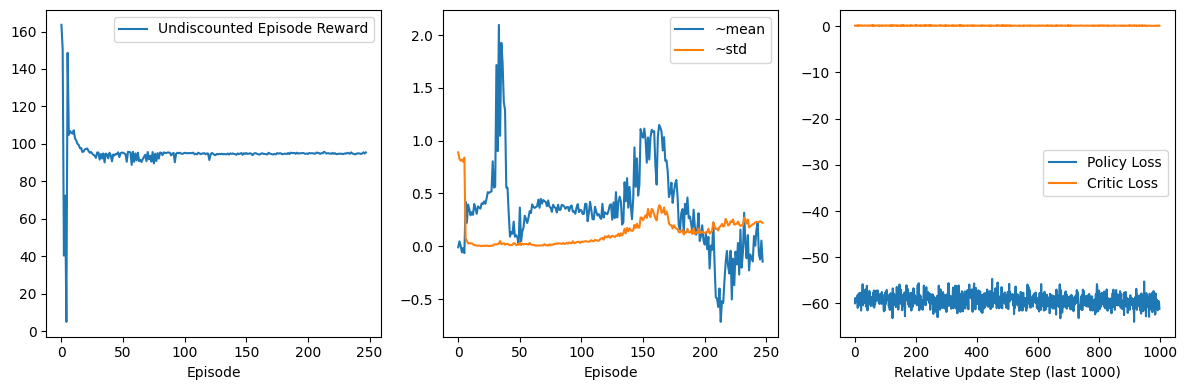

---


In [8]:
# train
max_episodes = 2000

reward_history = []
actor_loss_history = []
critic_loss_history = []
means = []
stds = []

try: env.reset(), env.close()
except: pass
env = gym.make(env_name)

try:
    t0 = time.time()
    shape_modifier = 1
    while len(memory) < learning_starts:
        state, _ = env.reset()
        for step in range(max_steps):
            action = env.action_space.sample()
            next_state, reward, terminated, truncated, _ = env.step(action)
            reward += abs(state[1]) * 20.0 * shape_modifier  # reward shaping, add a reward for speed
            memory.push(state, action, reward, next_state, terminated)  # (s, a, r, s', TERM_FLAG)
            state = next_state
            if len(memory) % 100 == 0:
                clear_output(wait=True)
                print(f'time {time.time() - t0:.2f} s')
                print(f'collecting initial training data {len(memory)}/{learning_starts}')
                
            if terminated or truncated:
                break

    total_steps = 0
    t0 = time.time()
    t1 = time.time()
    for episode in range(1, max_episodes+1):
        state, _ = env.reset()
        episode_reward = 0
        
        t3 = time.time()
        for step in range(1, max_steps+1):
            action = policy(state)
            next_state, reward, terminated, truncated, _ = env.step(action.numpy())
            
            reward += abs(state[1]) * 20.0 * shape_modifier  # reward shaping, add a reward for speed
            shape_modifier *= 0.9997  # decay it
            if total_steps >= 20000: shape_modifier = 0  # set to 0
                
            memory.push(state, action, reward, next_state, terminated)  # (s, a, r, s', TERM_FLAG)
            episode_reward += reward
            state = next_state
    
            actor_loss, critic_loss = update()
            actor_loss_history.append(actor_loss)
            critic_loss_history.append(critic_loss)
            
            if terminated or truncated:
                break
        te = time.time() - t3

        total_steps += step
        reward_history.append(episode_reward)
        
        with torch.no_grad():
            mean, log_std = actor(torch.as_tensor(state))
        std = log_std.exp()
        means.append(mean.item())
        stds.append(std.item())
    
        if time.time() - t1 > 2 and len(memory) >= learning_starts:
            t1 = time.time()
            
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 3, 1)
            plt.plot(reward_history, label='Undiscounted Episode Reward')
            plt.xlabel('Episode')
            plt.legend()
            plt.subplot(1, 3, 2)
            plt.plot(means, label='~mean')
            plt.plot(stds, label='~std')
            plt.xlabel('Episode')
            plt.legend()
            plt.subplot(1, 3, 3)
            plt.plot(actor_loss_history[-1000:], label='Policy Loss')
            plt.plot(critic_loss_history[-1000:], label='Critic Loss')
            plt.xlabel('Relative Update Step (last 1000)')
            plt.legend()
            plt.tight_layout()
            
            clear_output(wait=True)
            print(f'time {time.time() - t0:.2f} s')
            print(f'steps {total_steps}  [{step/te:.1f}/s]')
            print(f'alpha {alpha.item():.4f}')
            print(f'memory size {len(memory)}')
            plt.show()
            
except KeyboardInterrupt:
    print('---')
finally:
    env.close()

In [21]:
# play
try:
    env = gym.make(env_name, render_mode='human')
    state, _ = env.reset()
    rewards = 0
    for step in range(1, max_steps+1):
        action = policy(state, stochastic=False).numpy()
        state, reward, terminated, truncated, _ = env.step(action)
        rewards += reward
        clear_output(wait=True)
        print(f'taking action {action}')
        if terminated or truncated:
            break
    print('step', step, ' total rewards:', rewards)
except KeyboardInterrupt:
    print('---')
finally:
    env.close()

taking action [-0.04282961]
step 73  total rewards: 94.83548539857576


In [10]:
# save
import os
os.makedirs('./saved', exist_ok=True)
torch.save(actor.state_dict(), f'./saved/{env_name}-actor.pth')
torch.save(online_critic.state_dict(), f'./saved/{env_name}-critic.pth')
print('saved')

saved
